Positive cases: 34979
Negative cases: 35021


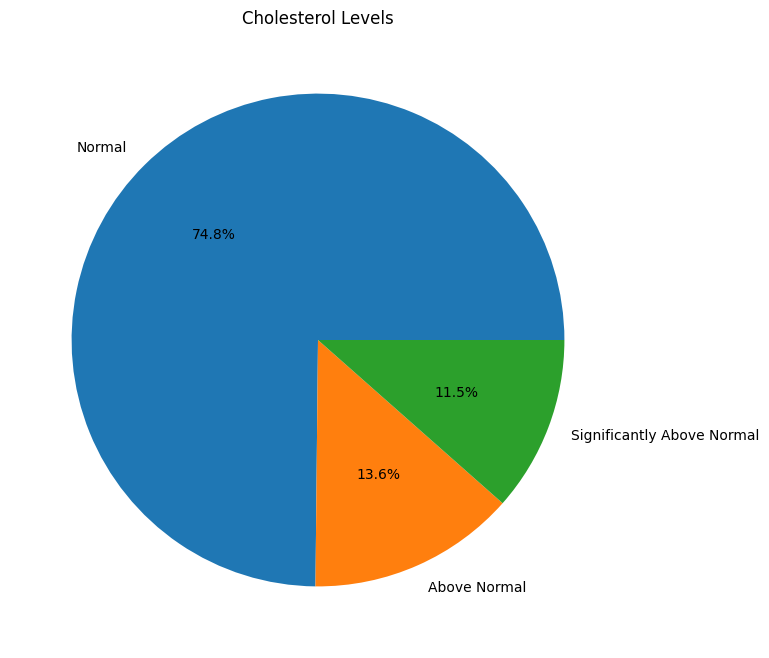

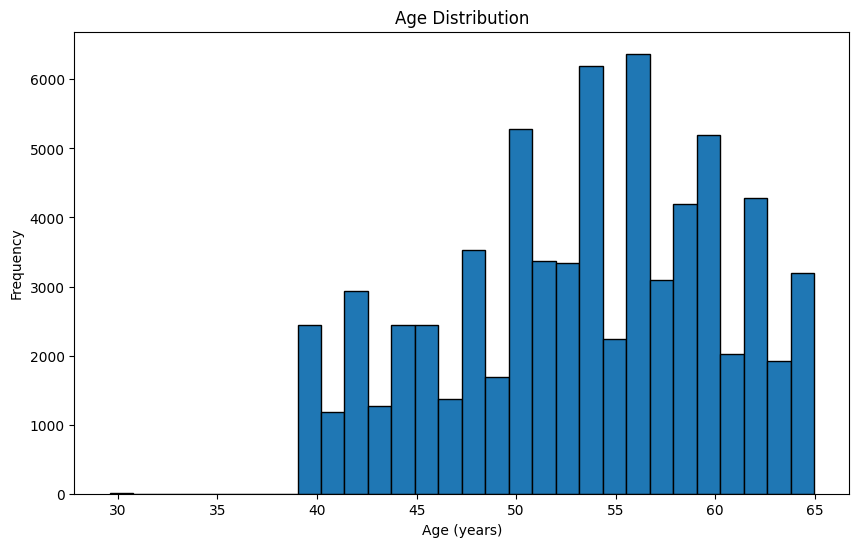

Percentage of smokers: 8.81%


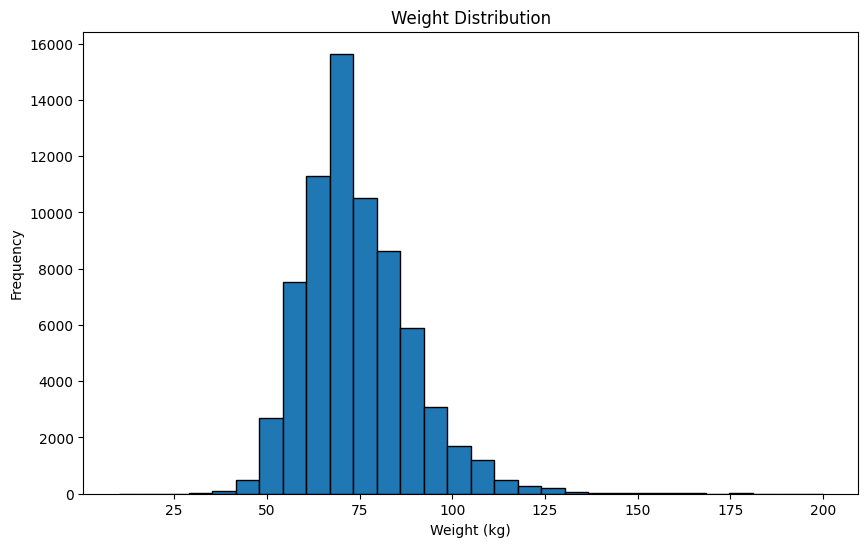

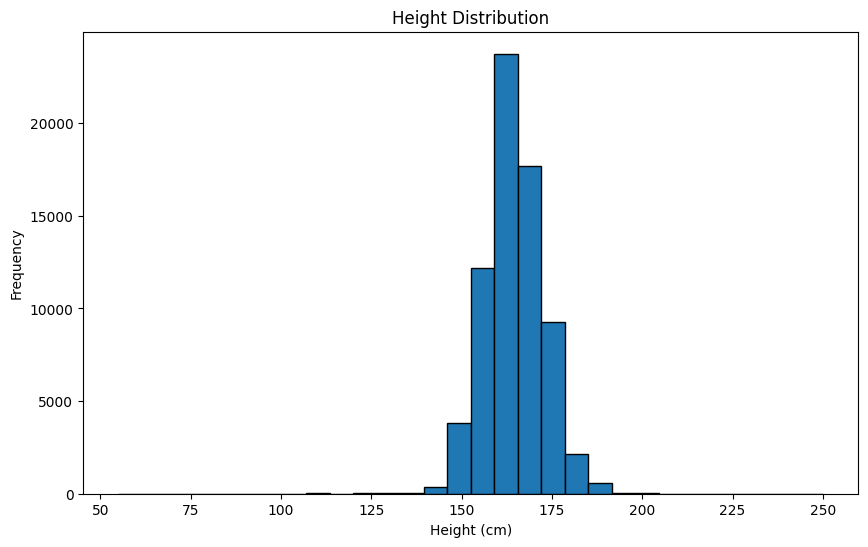

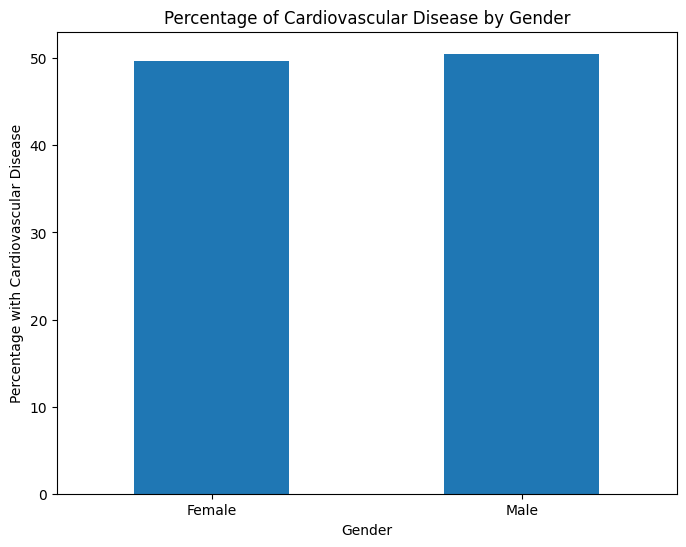

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



df = pd.read_csv('cardio_train.csv', sep=';')

# Räknar hur många positive o negative cases
positive_cases = df[df['cardio'] == 1].shape[0]
negative_cases = df[df['cardio'] == 0].shape[0]

print(f"Positive cases: {positive_cases}")
print(f"Negative cases: {negative_cases}")

# Skapar cholesterol kategorier
cholesterol_categories = {
    1: 'Normal',
    2: 'Above Normal',
    3: 'Significantly Above Normal'
}

# Räkna procent
cholesterol_counts = df['cholesterol'].value_counts(normalize=True) * 100

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(cholesterol_counts, labels=cholesterol_categories.values(), autopct='%1.1f%%')
plt.title('Cholesterol Levels')
plt.show()


# Gör så att åldrer visar år istället för dagar
df['age_years'] = df['age'] / 365

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['age_years'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.show()

smokers_percentage = df['smoke'].mean() * 100
print(f"Percentage of smokers: {smokers_percentage:.2f}%")


plt.figure(figsize=(10, 6))
plt.hist(df['weight'], bins=30, edgecolor='black')
plt.title('Weight Distribution')
plt.xlabel('Weight (kg)')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(10, 6))
plt.hist(df['height'], bins=30, edgecolor='black')
plt.title('Height Distribution')
plt.xlabel('Height (cm)')
plt.ylabel('Frequency')
plt.show()


# Räkna procent
gender_cardio = df.groupby('gender')['cardio'].mean() * 100

# Plot bar chart
gender_cardio.plot(kind='bar', figsize=(8, 6))
plt.title('Percentage of Cardiovascular Disease by Gender')
plt.xlabel('Gender')
plt.ylabel('Percentage with Cardiovascular Disease')
plt.xticks([0, 1], ['Female', 'Male'], rotation=0)
plt.show()




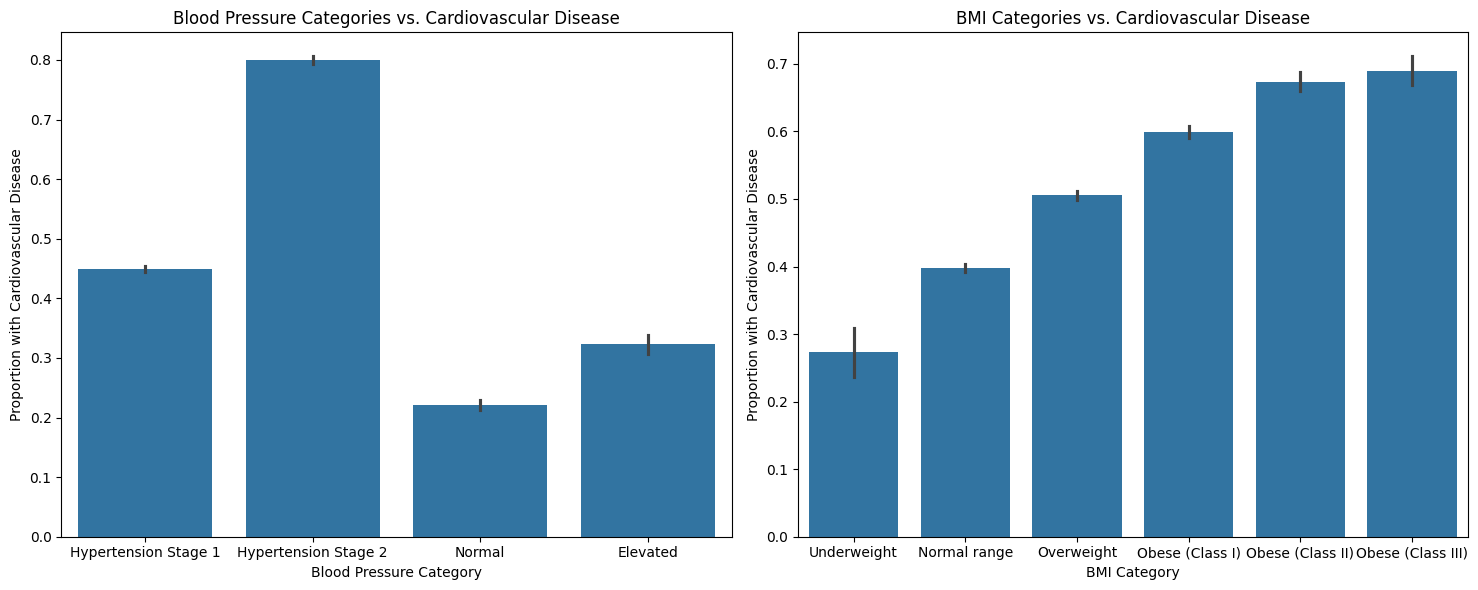

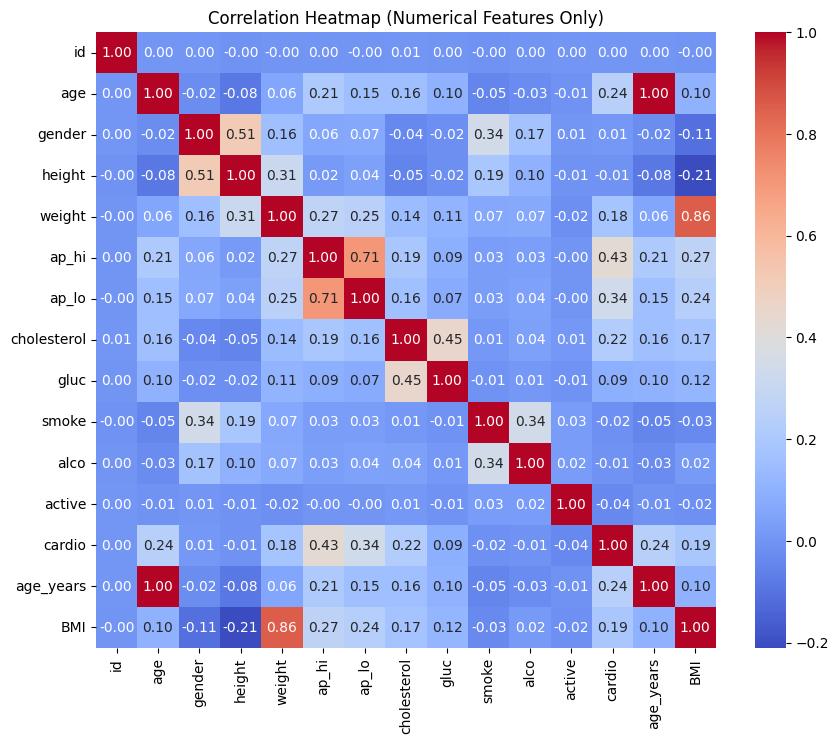

In [ ]:
df['BMI'] = df['weight'] / ((df['height'] / 100) ** 2)

# Skapar realistik BMI range (10 till 60)
df = df[(df['BMI'] >= 10) & (df['BMI'] <= 60)]

# Skapar BMI categories
bmi_categories = {
    (0, 18.5): 'Underweight',
    (18.5, 25): 'Normal range',
    (25, 30): 'Overweight',
    (30, 35): 'Obese (Class I)',
    (35, 40): 'Obese (Class II)',
    (40, 100): 'Obese (Class III)'
}

# Skapar BMI kategori features
df['BMI_category'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, 35, 40, 100], labels=bmi_categories.values())


# Skapar realistisk blood pressure range (50 till 250 för systolic och 30 till 150 för diastolic)
df = df[(df['ap_hi'] >= 50) & (df['ap_hi'] <= 250)]
df = df[(df['ap_lo'] >= 30) & (df['ap_lo'] <= 150)]

# Skapa blood pressure kategorier
def blood_pressure_category(systolic, diastolic):
    if systolic < 120 and diastolic < 80:
        return 'Normal'
    elif 120 <= systolic < 130 and diastolic < 80:
        return 'Elevated'
    elif 130 <= systolic < 140 or 80 <= diastolic < 90:
        return 'Hypertension Stage 1'
    elif systolic >= 140 or diastolic >= 90:
        return 'Hypertension Stage 2'
    else:
        return 'Hypertensive Crisis'

df['BP_category'] = df.apply(lambda row: blood_pressure_category(row['ap_hi'], row['ap_lo']), axis=1)

# Skapa subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Blood pressure kategorier vs proportion av positiva cases
sns.barplot(x='BP_category', y='cardio', data=df, ax=axes[0])
axes[0].set_title('Blood Pressure Categories vs. Cardiovascular Disease')
axes[0].set_xlabel('Blood Pressure Category')
axes[0].set_ylabel('Proportion with Cardiovascular Disease')

# BMI kategorier vs proportion av positive cases
sns.barplot(x='BMI_category', y='cardio', data=df, ax=axes[1])
axes[1].set_title('BMI Categories vs. Cardiovascular Disease')
axes[1].set_xlabel('BMI Category')
axes[1].set_ylabel('Proportion with Cardiovascular Disease')

plt.tight_layout()
plt.show()

numerical_df = df.select_dtypes(include=[np.number])
corr = numerical_df.corr()

# Plotta heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Numerical Features Only)')
plt.show()

In [ ]:
# Skapar första dataset 
df1 = df.drop(columns=["ap_hi", "ap_lo", "height", "weight", "BMI"])
df1 = pd.get_dummies(df1, columns=["BMI_category", "BP_category", "gender"], drop_first=True)


# skapar andra dataset 
df2 = df.drop(columns=["BMI_category", "BP_category", "height", "weight"])
df2 = pd.get_dummies(df2, columns=["gender"], drop_first=True)

# Kollar på datan så allt ser bra ut
df1.head(), df2.head()

(   id    age  cholesterol  gluc  smoke  alco  active  cardio  age_years  \
 0   0  18393            1     1      0     0       1       0  50.391781   
 1   1  20228            3     1      0     0       1       1  55.419178   
 2   2  18857            3     1      0     0       0       1  51.663014   
 3   3  17623            1     1      0     0       1       1  48.282192   
 4   4  17474            1     1      0     0       0       0  47.873973   
 
    BMI_category_Normal range  BMI_category_Overweight  \
 0                       True                    False   
 1                      False                    False   
 2                       True                    False   
 3                      False                     True   
 4                       True                    False   
 
    BMI_category_Obese (Class I)  BMI_category_Obese (Class II)  \
 0                         False                          False   
 1                          True                          

In [ ]:
# Splittar funktioner
def split_data(df):
    X = df.drop(columns=["id", "cardio"])
    y = df["cardio"]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Splittar både datasets
X_train1, X_val1, X_test1, y_train1, y_val1, y_test1 = split_data(df1)
X_train2, X_val2, X_test2, y_train2, y_val2, y_test2 = split_data(df2)

In [ ]:
# Skalar funktion
def scale_data(X_train, X_val, X_test):
    scaler_std = StandardScaler()
    X_train_std = scaler_std.fit_transform(X_train)
    X_val_std = scaler_std.transform(X_val)
    X_test_std = scaler_std.transform(X_test)
    
    scaler_norm = MinMaxScaler()
    X_train_norm = scaler_norm.fit_transform(X_train)
    X_val_norm = scaler_norm.transform(X_val)
    X_test_norm = scaler_norm.transform(X_test)
    
    return (X_train_std, X_val_std, X_test_std), (X_train_norm, X_val_norm, X_test_norm)

# Applicera skaling
(X_train1_std, X_val1_std, X_test1_std), (X_train1_norm, X_val1_norm, X_test1_norm) = scale_data(X_train1, X_val1, X_test1)
(X_train2_std, X_val2_std, X_test2_std), (X_train2_norm, X_val2_norm, X_test2_norm) = scale_data(X_train2, X_val2, X_test2)


In [ ]:

# Model hyperparameter grids
param_grid_lr = {"C": [0.01, 0.1, 1, 10, 100]}
param_grid_rf = {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]}
param_grid_svm = {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}

# Funktion för att träna modeller och tune hyperparametrar
def train_and_tune(X_train, X_val, y_train, y_val):
    models = {
        "LogisticRegression": (LogisticRegression(), param_grid_lr),
        "RandomForest": (RandomForestClassifier(), param_grid_rf),
        "SVM": (SVC(), param_grid_svm)
    }

    best_models = {}
    for name, (model, param_grid) in models.items():
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        
        best_models[name] = {"Best Model": best_model, "Accuracy": accuracy, "Best Params": grid_search.best_params_}
    
    return best_models

# Träna och tune models på båda both datasets
best_models_1 = train_and_tune(X_train1_std, X_val1_std, y_train1, y_val1)
best_models_2 = train_and_tune(X_train2_std, X_val2_std, y_train2, y_val2)

# Printar bästa models och parametrar
print("Best Models for Dataset 1:", best_models_1)
print("Best Models for Dataset 2:", best_models_2)



Best Models for Dataset 1: {'LogisticRegression': {'Best Model': LogisticRegression(C=0.01), 'Accuracy': 0.6995341614906833, 'Best Params': {'C': 0.01}}, 'RandomForest': {'Best Model': RandomForestClassifier(max_depth=10, n_estimators=50), 'Accuracy': 0.703610248447205, 'Best Params': {'max_depth': 10, 'n_estimators': 50}}, 'SVM': {'Best Model': SVC(C=1), 'Accuracy': 0.7061335403726708, 'Best Params': {'C': 1, 'kernel': 'rbf'}}}
Best Models for Dataset 2: {'LogisticRegression': {'Best Model': LogisticRegression(C=1), 'Accuracy': 0.7282608695652174, 'Best Params': {'C': 1}}, 'RandomForest': {'Best Model': RandomForestClassifier(max_depth=10, n_estimators=200), 'Accuracy': 0.7374805900621118, 'Best Params': {'max_depth': 10, 'n_estimators': 200}}, 'SVM': {'Best Model': SVC(C=0.1), 'Accuracy': 0.7382569875776398, 'Best Params': {'C': 0.1, 'kernel': 'rbf'}}}


Test Accuracy: 0.7380
Confusion Matrix:
 [[4101 1105]
 [1595 3504]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.79      0.75      5206
           1       0.76      0.69      0.72      5099

    accuracy                           0.74     10305
   macro avg       0.74      0.74      0.74     10305
weighted avg       0.74      0.74      0.74     10305



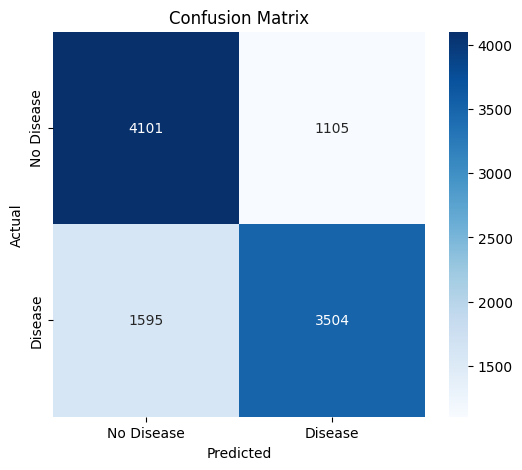

In [ ]:
# kombinerar tränar och validerar sets för final träningen
X_train_final = np.vstack((X_train2, X_val2))
y_train_final = np.hstack((y_train2, y_val2))

# Skala data med StandardScaler
scaler = StandardScaler()
X_train_final_std = scaler.fit_transform(X_train_final)
X_test2_std = scaler.transform(X_test2.to_numpy())


# Träna finala model
rf_model = RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)
rf_model.fit(X_train_final_std, y_train_final)

# Predictions
y_pred = rf_model.predict(X_test2_std)

# Evaluering metrics
accuracy = accuracy_score(y_test2, y_pred)
conf_matrix = confusion_matrix(y_test2, y_pred)
class_report = classification_report(y_test2, y_pred)

# Visa results
print(f"Test Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Testade en annan modell men randomforest gav mig bättre resultat
svm_model = SVC(C=0.1, kernel='rbf', random_state=42)
svm_model.fit(X_train_final_std, y_train_final)
y_pred_svm = svm_model.predict(X_test2_std)
print("SVM Model")
print(f"Test Accuracy: {accuracy_score(y_test2, y_pred_svm):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test2, y_pred_svm))
print("Classification Report:\n", classification_report(y_test2, y_pred_svm))

SVM Model
Test Accuracy: 0.7359
Confusion Matrix:
 [[4086 1120]
 [1602 3497]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.78      0.75      5206
           1       0.76      0.69      0.72      5099

    accuracy                           0.74     10305
   macro avg       0.74      0.74      0.73     10305
weighted avg       0.74      0.74      0.74     10305

